In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import skew, kurtosis, norm
from scipy.linalg import sqrtm
import yfinance as yf
import cvxpy as cp
import riskfolio as rp
import seaborn as sns

In [2]:

# Cargar los archivos usando ';' como separador
df1 = pd.read_csv('Datos históricos 0P0000A1U1.csv', sep=';')
df2 = pd.read_csv('Datos históricos del S&P 500.csv', sep=';')

# Renombrar las columnas para diferenciar los precios de cada fuente
df1.rename(columns={'Precio': 'JPM'}, inplace=True)
df2.rename(columns={'Precio': 'SP500'}, inplace=True)
# Convertir las fechas al mismo formato y tipo
df1['Fecha'] = pd.to_datetime(df1['Fecha'], dayfirst=True)
df2['Fecha'] = pd.to_datetime(df2['Fecha'], dayfirst=True)

# Unir los DataFrames por la columna de fecha
combined_df = pd.merge(df1, df2, on='Fecha', how='outer').sort_values('Fecha')

# Mostrar el DataFrame combinado
print(combined_df.head())


       Fecha     JPM     SP500
0 2019-01-01  22,010  2.704,10
1 2019-02-01  23,220  2.784,49
2 2019-03-01  23,590  2.834,40
3 2019-04-01  24,600  2.945,83
4 2019-05-01  23,530  2.752,06


In [3]:
combined_df = combined_df.set_index('Fecha')
combined_df.head()


,JPM,SP500
Fecha,,
2019-01-01,"22,010","2.704,10"
2019-02-01,"23,220","2.784,49"
2019-03-01,"23,590","2.834,40"
2019-04-01,"24,600","2.945,83"
2019-05-01,"23,530","2.752,06"


In [4]:
# Hacer que la fechas vayan de '2019-01-01' hasta '2023-11-01'
combined_df = combined_df.loc['2019-01-01':'2023-11-01']
combined_df.head()

,JPM,SP500
Fecha,,
2019-01-01,"22,010","2.704,10"
2019-02-01,"23,220","2.784,49"
2019-03-01,"23,590","2.834,40"
2019-04-01,"24,600","2.945,83"
2019-05-01,"23,530","2.752,06"


In [5]:
combined_df['JPM'] = combined_df['JPM'].str.replace('.', '').str.replace(',', '.').astype(float)
combined_df['SP500'] = combined_df['SP500'].str.replace('.', '').str.replace(',', '.').astype(float)

In [6]:
precios_fondo = combined_df['JPM']
precios_indice = combined_df['SP500']

In [7]:
retornos_fondo= np.log(precios_fondo).diff().dropna()
retornos_indice = np.log(precios_indice).diff().dropna()

In [9]:
retornos = pd.concat([retornos_fondo, retornos_indice], axis=1).dropna()
retornos.head()

,JPM,SP500
Fecha,,
2019-02-01,0.053517,0.029296
2019-03-01,0.015809,0.017766
2019-04-01,0.041924,0.038560
2019-05-01,-0.044470,-0.068041
2019-06-01,0.064990,0.066658


In [10]:
retornos_fondo.head()

Fecha
2019-02-01    0.053517
2019-03-01    0.015809
2019-04-01    0.041924
2019-05-01   -0.044470
2019-06-01    0.064990
Name: JPM, dtype: float64

In [11]:
retornos_indice.head()

Fecha
2019-02-01    0.029296
2019-03-01    0.017766
2019-04-01    0.038560
2019-05-01   -0.068041
2019-06-01    0.066658
Name: SP500, dtype: float64

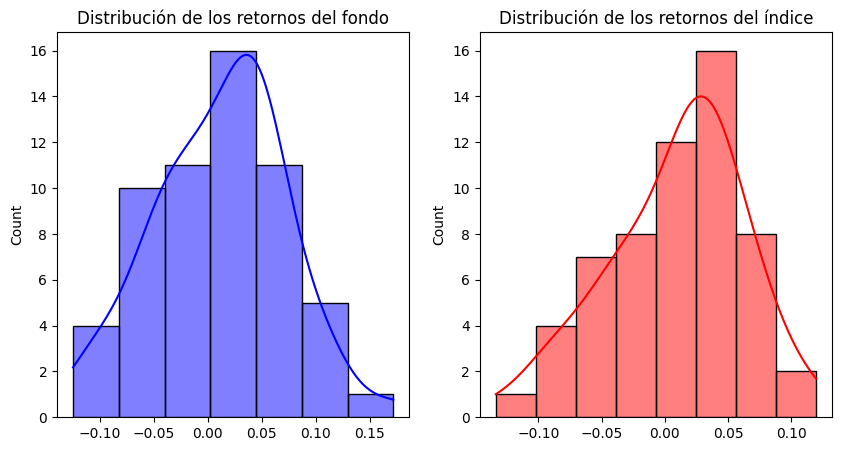

In [35]:
#plot kurtosis 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(retornos_fondo, kde=True, color='b')
plt.title('Distribución de los retornos del fondo')
plt.subplot(1, 2, 2)
sns.histplot(retornos_indice, kde=True, color='r')
plt.title('Distribución de los retornos del índice')
plt.show()


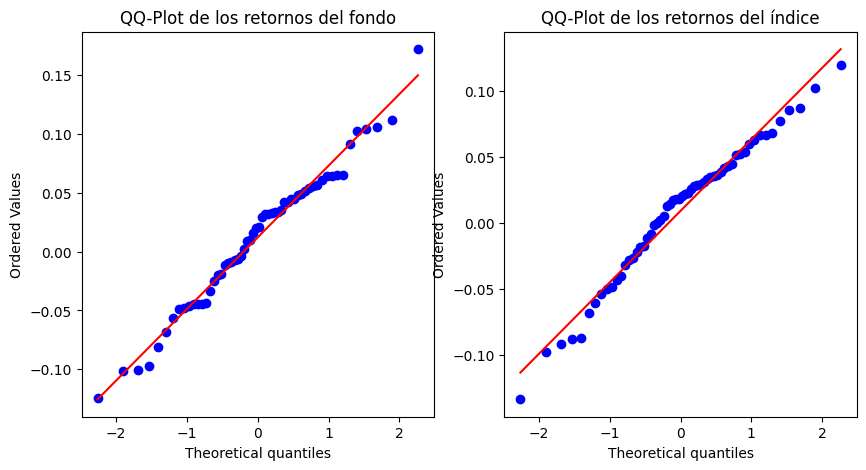

In [37]:
#plot the type of distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
stats.probplot(retornos_fondo, dist="norm", plot=plt)
plt.title('QQ-Plot de los retornos del fondo')
plt.subplot(1, 2, 2)
stats.probplot(retornos_indice, dist="norm", plot=plt)
plt.title('QQ-Plot de los retornos del índice')
plt.show()



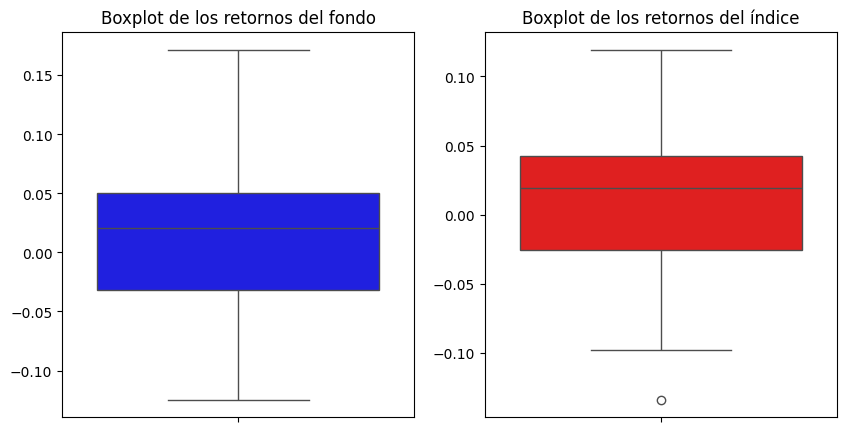

In [43]:
#grafico de caja
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=retornos_fondo, color='b')
plt.title('Boxplot de los retornos del fondo')
plt.subplot(1, 2, 2)
sns.boxplot(data=retornos_indice, color='r')
plt.title('Boxplot de los retornos del índice')
plt.show()



C:\Users\nacho\AppData\Local\Temp\ipykernel_13972\2101598380.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Empresa'], rotation=45, ha='right')


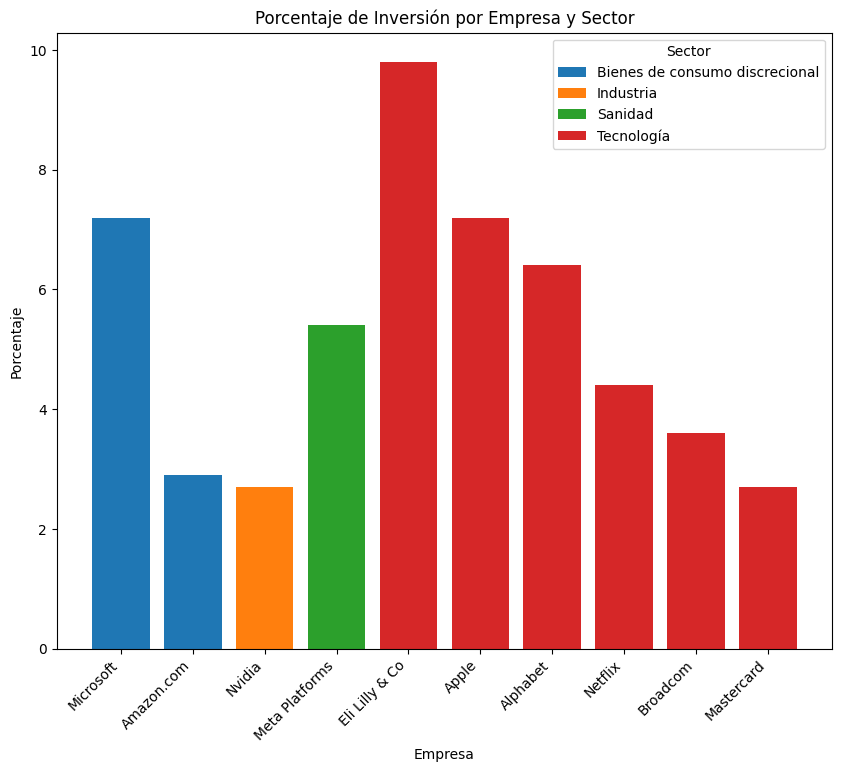

In [45]:
data = {
    'Empresa': ['Microsoft', 'Amazon.com', 'Nvidia', 'Meta Platforms', 'Eli Lilly & Co', 'Apple', 'Alphabet', 'Netflix', 'Broadcom', 'Mastercard'],
    'Sector': ['Tecnología', 'Bienes de consumo discrecional', 'Tecnología', 'Tecnología', 'Sanidad', 'Tecnología', 'Tecnología', 'Bienes de consumo discrecional', 'Tecnología', 'Industria'],
    'Porcentaje': [9.8, 7.2, 7.2, 6.4, 5.4, 4.4, 3.6, 2.9, 2.7, 2.7]
}

# Crear DataFrame
df = pd.DataFrame(data)

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 8))
for sector, group in df.groupby('Sector'):
    ax.bar(group['Empresa'], group['Porcentaje'], label=sector)

# Añadir título y etiquetas
ax.set_title('Porcentaje de Inversión por Empresa y Sector')
ax.set_xlabel('Empresa')
ax.set_ylabel('Porcentaje')
ax.set_xticklabels(df['Empresa'], rotation=45, ha='right')
ax.legend(title='Sector')

# Mostrar gráfico
plt.show()

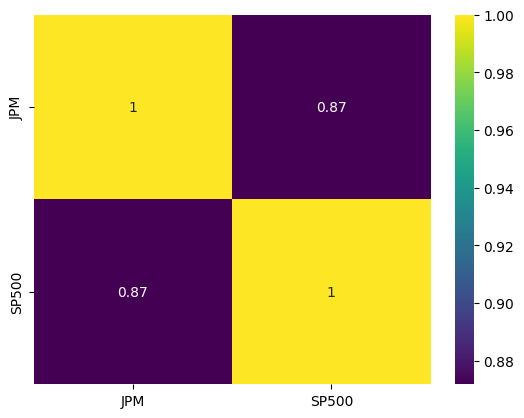

In [12]:

sns.heatmap(retornos_fondo.to_frame().join(retornos_indice).corr(), annot=True, cmap='viridis')
plt.show()


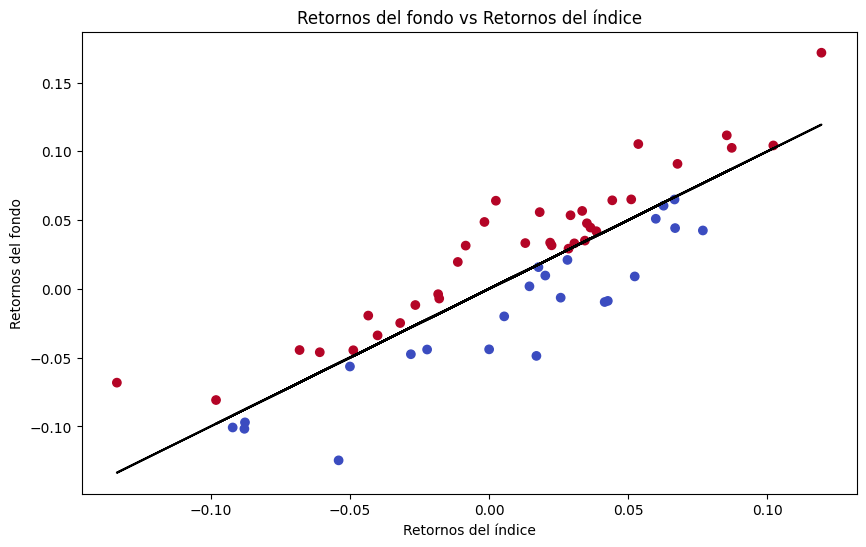

In [13]:

plt.figure(figsize=(10, 6))
plt.scatter(retornos_indice, retornos_fondo, c=np.sign(retornos_fondo-retornos_indice), cmap='coolwarm')
plt.plot(retornos_indice, retornos_indice, color='black')
plt.xlabel('Retornos del índice')
plt.ylabel('Retornos del fondo')
plt.title('Retornos del fondo vs Retornos del índice')
plt.show()




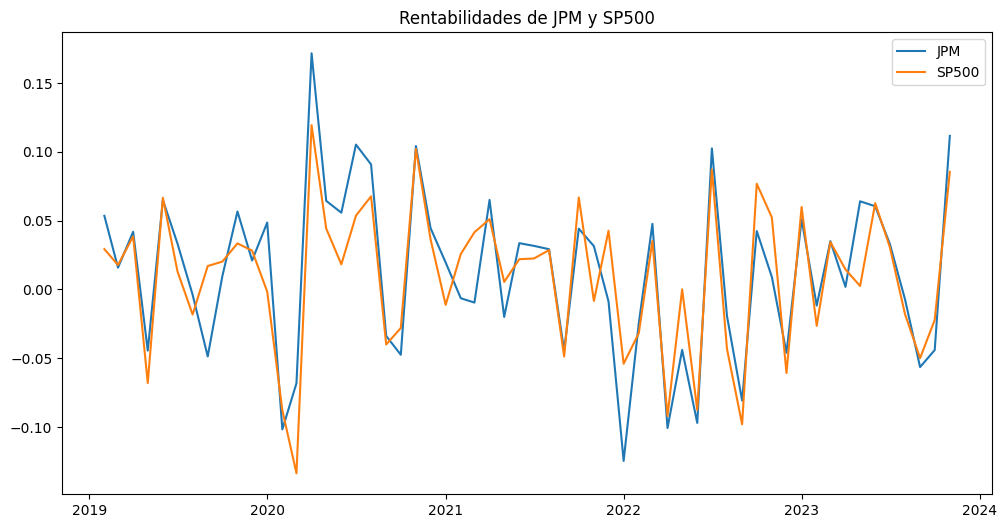

In [14]:
#graficar las rentabilidades

plt.figure(figsize=(12, 6))
plt.plot(retornos_fondo, label='JPM')
plt.plot(retornos_indice, label='SP500')
plt.legend()
plt.title('Rentabilidades de JPM y SP500')
plt.show()


In [15]:
ff_factors = pd.read_csv('F-F_Research_Data_Factors_monthly.csv', index_col=0, parse_dates=True)

ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-01,2.96,-2.56,-2.43,0.22
1926-08-01,2.64,-1.17,3.82,0.25
1926-09-01,0.36,-1.40,0.13,0.23
1926-10-01,-3.24,-0.09,0.70,0.32
1926-11-01,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2023-07-01,3.21,2.08,4.11,0.45
2023-08-01,-2.39,-3.16,-1.06,0.45
2023-09-01,-5.24,-2.51,1.52,0.43
2023-10-01,-3.19,-3.87,0.19,0.47


In [16]:
ff_factors = ff_factors / 100
ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-01,0.0296,-0.0256,-0.0243,0.0022
1926-08-01,0.0264,-0.0117,0.0382,0.0025
1926-09-01,0.0036,-0.0140,0.0013,0.0023
1926-10-01,-0.0324,-0.0009,0.0070,0.0032
1926-11-01,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2023-07-01,0.0321,0.0208,0.0411,0.0045
2023-08-01,-0.0239,-0.0316,-0.0106,0.0045
2023-09-01,-0.0524,-0.0251,0.0152,0.0043
2023-10-01,-0.0319,-0.0387,0.0019,0.0047


In [17]:
precios_factors = np.exp(ff_factors.cumsum())

In [18]:
precios_factors.head()

,Mkt-RF,SMB,HML,RF
1926-07-01,1.030042,0.974725,0.975993,1.002202
1926-08-01,1.057598,0.963387,1.013997,1.004711
1926-09-01,1.061412,0.949994,1.015316,1.007025
1926-10-01,1.027573,0.949139,1.022448,1.010252
1926-11-01,1.053903,0.948190,1.017247,1.013389


In [19]:

START_DATE='2019-01-01'
END_DATE='2023-11-01'
precios_factors = precios_factors.loc[START_DATE:END_DATE]
precios_factors.head()

,Mkt-RF,SMB,HML,RF
2019-01-01,1490.102219,9.351156,59.507360,21.014234
2019-02-01,1541.636818,9.544833,57.939537,21.052093
2019-03-01,1558.688435,9.258111,55.573140,21.092130
2019-04-01,1621.813100,9.098413,56.780900,21.136470
2019-05-01,1513.076085,8.979103,55.451014,21.180904
2019-06-01,1621.650927,9.005180,55.058706,21.219064
2019-07-01,1641.063851,8.833047,55.323623,21.259418
2019-08-01,1599.265915,8.625302,52.741362,21.293460
2019-09-01,1622.299717,8.542895,56.424305,21.331823
2019-10-01,1656.065687,8.567706,55.356827,21.365981


In [20]:
datos_df = pd.concat([ff_factors, retornos_fondo], axis=1, join='inner')
datos_df.columns = list(ff_factors.columns) + ['JPM']
datos_df.head(5)

,Mkt-RF,SMB,HML,RF,JPM
2019-02-01,0.0340,0.0205,-0.0267,0.0018,0.053517
2019-03-01,0.0110,-0.0305,-0.0417,0.0019,0.015809
2019-04-01,0.0397,-0.0174,0.0215,0.0021,0.041924
2019-05-01,-0.0694,-0.0132,-0.0237,0.0021,-0.044470
2019-06-01,0.0693,0.0029,-0.0071,0.0018,0.064990


In [21]:
datos_df['Mkt-RF'] = retornos_indice

In [22]:
datos_df.head()


,Mkt-RF,SMB,HML,RF,JPM
2019-02-01,0.029296,0.0205,-0.0267,0.0018,0.053517
2019-03-01,0.017766,-0.0305,-0.0417,0.0019,0.015809
2019-04-01,0.038560,-0.0174,0.0215,0.0021,0.041924
2019-05-01,-0.068041,-0.0132,-0.0237,0.0021,-0.044470
2019-06-01,0.066658,0.0029,-0.0071,0.0018,0.064990


In [24]:
datos_df['Mkt-RF'] = datos_df['Mkt-RF'] - datos_df['RF']
datos_df.head()

,Mkt-RF,SMB,HML,RF,JPM
2019-02-01,0.027496,0.0205,-0.0267,0.0018,0.053517
2019-03-01,0.015866,-0.0305,-0.0417,0.0019,0.015809
2019-04-01,0.036460,-0.0174,0.0215,0.0021,0.041924
2019-05-01,-0.070141,-0.0132,-0.0237,0.0021,-0.044470
2019-06-01,0.064858,0.0029,-0.0071,0.0018,0.064990


In [25]:
Y = datos_df.loc[:, 'JPM']-datos_df['RF']
X = datos_df[['Mkt-RF', 'SMB', 'HML']]

X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     129.4
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           1.23e-24
Time:                        20:38:25   Log-Likelihood:                 142.41
No. Observations:                  58   AIC:                            -276.8
Df Residuals:                      54   BIC:                            -268.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.123      0.2

In [26]:
#ratio de sharpe

retornos_fondo = np.array(retornos_fondo)
retornos_indice = np.array(retornos_indice)

# Calcular el retorno medio del fondo
retorno_medio_fondo = np.mean(retornos_fondo)*12

# Calcular la desviación estándar del fondo
desviacion_estandar_fondo = np.std(retornos_fondo)*np.sqrt(12)

# Suponer una tasa libre de riesgo de 0 si no tienes esta información
tasa_libre_riesgo = np.mean(datos_df['RF']) * 12

# Calcular el Ratio de Sharpe
sharpe_ratio = (retorno_medio_fondo - tasa_libre_riesgo) / desviacion_estandar_fondo

print("El Ratio de Sharpe es:", sharpe_ratio)


El Ratio de Sharpe es: 0.6231061096943882


In [27]:
def calculate_max_drawdown(prices):
    peak = prices.max()
    trough = prices.min()
    drawdown = (trough - peak) / peak
    return drawdown


max_drawdown_fondo = calculate_max_drawdown(precios_fondo)
max_drawdown_indice = calculate_max_drawdown(precios_indice)

print("Maximum Drawdown:", max_drawdown_fondo)
print("Maximum Drawdown:", max_drawdown_indice)

Maximum Drawdown: -0.5544534412955465
Maximum Drawdown: -0.4577229563298071
